In [1]:
pip install Gensim==3.8.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import gensim 
import random
from tqdm import tqdm
from gensim.models import Word2Vec 

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

import warnings;
warnings.filterwarnings('ignore')

In [34]:
df1=pd.read_csv("C:/Users/Матвей/Downloads/farm.csv")
df1.head()

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
0,2018-12-07,1260627,1455.0,168308.0,(197312) Пакет-майка 25см х 45см,906.0,205.0,-1.0,"1,00"
1,2018-12-07,198287,279.0,134832.0,(62448) Перекись водорода р-р наружн. 3% фл.по...,404.0,93.0,-1.0,"1,00"
2,2018-12-07,2418385,848.0,101384.0,(72183) Салициловая кислота р-р спирт 2% фл 40...,404.0,93.0,-1.0,"1,00"
3,2018-12-07,1285774,1511.0,168570.0,(197309) Пакет 28см х 50см,906.0,205.0,-1.0,"1,00"
4,2018-12-07,1810323,1501.0,168319.0,(197310) Пакет 30см х 60см,906.0,205.0,-1.0,"1,00"


In [35]:
df1.shape

(20000003, 9)

In [36]:
df1 = df1.fillna(0)

In [37]:
df1 ['shop_id']= df1['shop_id'].astype(int)

In [38]:
df1 ['shop_id']

0           1455
1            279
2            848
3           1511
4           1501
            ... 
19999998    1485
19999999    1503
20000000       0
20000001       0
20000002       0
Name: shop_id, Length: 20000003, dtype: int32

In [39]:
df1 = df1.drop(df1[df1.shop_id > 100].index)

In [40]:
df1.shape

(797585, 9)

In [41]:
df1

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
5,2018-12-07,2435604,66,37505.0,(53208) Кеппра таб.п.п.о.500мг №30,641.0,146.0,-1.0,"1,00"
46,2018-12-07,2746014,43,34104.0,(88540) Флуконазол капс. 150мг №2,622.0,142.0,-1.0,"2,00"
53,2018-12-07,2742588,52,27063.0,(116349) Нафтизин р-р 0.1% фл/кап 20мл N1,701.0,162.0,-1.0,"2,00"
56,2018-12-07,2742588,52,116091.0,(36435) Аевит капс N10,-1.0,-1.0,-1.0,"2,00"
89,2018-12-07,2745721,52,135018.0,(61001) Дьюралан 60мг шприц 3мл уп.№1,646.0,148.0,-1.0,"2,00"
...,...,...,...,...,...,...,...,...,...
19988836,2018-06-13,319155,51,102740.0,(42652) Валокордин капли д/приема внутрь 50мл,613.0,140.0,-1.0,"1,00"
19988859,2018-06-13,1010890,57,157284.0,(179696) Ван Тач Селект Плюс Глюкометр,454.0,106.0,2933.0,"1,00"
20000000,0,0,0,0.0,0,0.0,0.0,0.0,0
20000001,(затронуто стр,к: 20000000,0,0.0,0,0.0,0.0,0.0,0


In [42]:
df1.dtypes

sale_date_date              object
contact_id                  object
shop_id                      int32
product_id                 float64
name                        object
product_sub_category_id    float64
product_category_id        float64
brand_id                   float64
quantity                    object
dtype: object

In [43]:
df1 ['product_id'] = df1 ['product_id']. astype (str)

In [44]:
df1['brand_id'].describe()

count    797585.000000
mean        416.200658
std         981.046614
min          -1.000000
25%          -1.000000
50%          -1.000000
75%          -1.000000
max        5467.000000
Name: brand_id, dtype: float64

In [45]:
del df1['brand_id']

#### Уникальные клиенты

In [46]:
customers = df1 ["contact_id"]. unique (). tolist ()
len (customers)

74363

#### Выделим небольшую часть набора данных, 90% клиентов для создания вложений word2vec. Разделим данные.

In [47]:
random.shuffle(customers)

customers_train = [customers[i] for i in range(round(0.9*len(customers)))]


train_df1 = df1[df1['contact_id'].isin(customers_train)]
validation_df1 = df1[~df1['contact_id'].isin(customers_train)]

#### Cоздадим последовательности покупок, сделанных клиентами, в наборе данных.

In [48]:
purchases_train = []

for i in tqdm(customers_train):
    temp = train_df1[train_df1["contact_id"] == i]["product_id"].tolist()
    purchases_train.append(temp)

100%|██████████████████████████████████████████████████████████████████████████| 66927/66927 [1:20:08<00:00, 13.92it/s]


In [49]:
purchases_val = []

for i in tqdm(validation_df1['contact_id'].unique()):
    temp = validation_df1[validation_df1["contact_id"] == i]["product_id"].tolist()
    purchases_val.append(temp)

100%|██████████████████████████████████████████████████████████████████████████████| 7436/7436 [01:26<00:00, 86.46it/s]


#### Создание вложений word2vec для продуктов

In [50]:
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, 
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(6962436, 7159670)

In [51]:
model.init_sims(replace=True)

In [52]:
print(model)

Word2Vec(vocab=9331, size=100, alpha=0.03)


#### Наша модель имеет словарь из 9331 уникального слова и их векторов размером 100 каждый. Затем мы извлечем векторы всех слов в нашем словаре и сохраним их в одном месте для легкого доступа.

In [53]:
X = model[model.wv.vocab]

X.shape

(9331, 100)

In [54]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


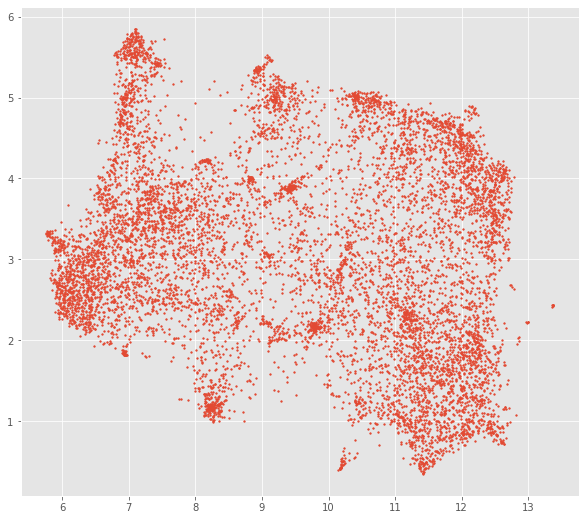

In [55]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [56]:
products = train_df1[["product_id", "name"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='product_id', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('product_id')['name'].apply(list).to_dict()

#### Проверка словаря

In [70]:
products_dict ['134832.0']

['(62448) Перекись водорода р-р наружн. 3% фл.полимерн. 100мл']

In [71]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms  

In [72]:
similar_products(model['134832.0'])

[('(96724) Бриллиантовый зеленый р-р спирт 1% фл 10мл N1 с лопаткой Renewal',
  0.6598858833312988),
 ('(114892) Нью Лайф Бинт марл мед стер 5м х 10см уп N1/СТМ',
  0.6511977910995483),
 ('(81509) PL Хлоргексидин биглюконат р-р 0.05% фл.100мл №1 (НДС 18%)',
  0.6501666307449341),
 ('(108159) Бриллиантовый зеленый р-р спирт 1% фл 25мл N1',
  0.6385761499404907),
 ('(114497) Доктор Йод раствор антисептический фл.10мл с крышкой-помазком',
  0.632773220539093),
 ('(69992) Клеенка подкладная ПВХ покрыт 1 х 0,68м', 0.6235135197639465)]

#### Результаты довольно актуальны и хорошо соответствуют исходному продукту. Однако этот вывод основан на векторе только одного продукта. Возьмем среднее значение всех векторов продуктов

In [78]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [79]:
len(purchases_val[0])

4

In [80]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [81]:
similar_products(aggregate_vectors(purchases_val[0]))

[('(33010) Пертуссин сироп фл 100мл N1', 0.6829351186752319),
 ('(119799) АВЕН КЛИНАНС Эмульсия солцезащитная SPF 50+ 50мл',
  0.6641629338264465),
 ('(36435) Аевит капс N10', 0.6590448021888733),
 ('(114421) Чемеричная вода р-р фл 100мл N1', 0.6568765640258789),
 ('(111779) Валсартан-Гидрохлоротиазид таб. п.п.о. 160мг+12,5мг №28',
  0.6476302146911621),
 ('(67032) Компливит Триместриум (2 триместр) табл. №30', 0.6458255648612976)]

In [82]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('(33010) Пертуссин сироп фл 100мл N1', 0.6829351186752319),
 ('(119799) АВЕН КЛИНАНС Эмульсия солцезащитная SPF 50+ 50мл',
  0.6641629338264465),
 ('(36435) Аевит капс N10', 0.6590448021888733),
 ('(114421) Чемеричная вода р-р фл 100мл N1', 0.6568765640258789),
 ('(111779) Валсартан-Гидрохлоротиазид таб. п.п.о. 160мг+12,5мг №28',
  0.6476302146911621),
 ('(67032) Компливит Триместриум (2 триместр) табл. №30', 0.6458255648612976)]